In [1]:
import calibr8
import numpy
import pandas
import pathlib
import matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as ticker

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Model creation

C:\Users\steier\AppData\Local\Continuum\miniconda3\envs\Amplify\lib\site-packages\calibr8\utils.py:526: UserWarning: Scale/sigma degree >= 2 is quite unusual. Consider a lower value.
  warnings.warn("Scale/sigma degree >= 2 is quite unusual. Consider a lower value.", UserWarning)


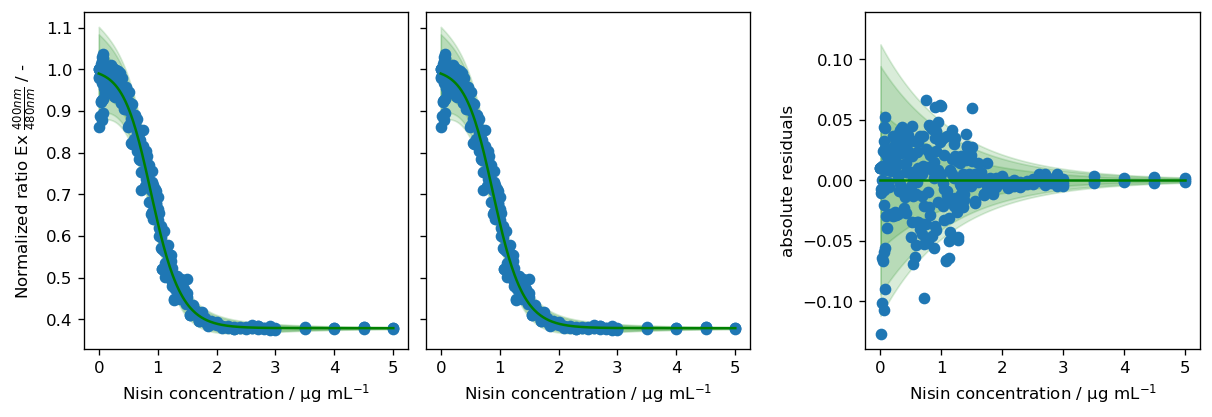

In [3]:
# Define model class
class NisinCalibrationModel(calibr8.BaseAsymmetricLogisticN):
    def __init__(
        self,
        *,
        independent_key: str="Nisin concentration / µg mL$^{-1}$",
        dependent_key: str=r"Normalized ratio Ex $\frac{400 nm}{480 nm}$ / -",
        sigma_degree: int=2, # this is just a helper to allow for the exponential sigma
        theta_names= tuple("L_L,L_U,I_x,S,c,I_sigma,L_sigma,k_sigma".split(",")),
    ):
        super().__init__(
            independent_key=independent_key,
            dependent_key=dependent_key,
            sigma_degree=sigma_degree,
            theta_names=theta_names,
        )
    def predict_dependent(self, x, *, theta=None):
        """Predicts the parameters mu and sigma of a normal distribution which
        characterizes the dependent variable given values of the independent variable.

        Parameters
        ----------
        x : array-like
            values of the independent variable
        theta : optional, array-like
            parameter vector of the calibration model:
                5 parameters of asymmetric logistic model for mu
                [sigma_degree] parameters for sigma (lowest degree first)

        Returns
        -------
        mu : array-like
            values for the mu parameter of a normal distribution describing the dependent variable
        sigma : array-like or float
            values for the sigma parameter of a normal distribution describing the dependent variable
        """
        if theta is None:
            theta = self.theta_fitted
        mu = calibr8.asymmetric_logistic(x, theta[:5])
        if self.sigma_degree == 0:
            sigma = theta[-1]
        else:
            sigma = calibr8.exponential(x, theta[5:])
        return mu, sigma


# Load your dataset
df_data = pandas.read_excel("calibration data.xlsx")
cal_independent = df_data["Concentration [µg/mL]"]
cal_dependent = df_data["normalized fluorescence ratio"]

# Fit the model
Pahpshmirmodel = NisinCalibrationModel()
calibr8.fit_scipy(
    Pahpshmirmodel,
    independent=cal_independent.to_numpy(),
    dependent=cal_dependent.to_numpy(),
    theta_guess=[0.3, 1.05, 1.0, -1.0, 0.1, 0.3, 0.01, 0.8],
    theta_bounds=[
        (0.2, 0.5),
        (0.8, 1.2),
        (0.0, 2.0),
        (-2.0, 0),
        (-1.0, 1.0),
        (0.00001, 0.5),
        (0.00001, 0.2),
        (0.01, 2),
    ],
)

# Plot the residuals
fig, axs = calibr8.plot_model(Pahpshmirmodel)